In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from numpy.linalg import inv
import matplotlib.pyplot as plt

### 3. Preparing the Data for Estimatation

The “hard part” of the MNL likelihood function is organizing the data, as we need to keep track of 3 dimensions (consumer 
, covariate 
, and product 
) instead of the typical 2 dimensions for cross-sectional regression models (consumer 
 and covariate 
). The fact that each task for each respondent has the same number of alternatives (3) helps. In addition, we need to convert the categorical variables for brand and ads into binary variables.

todo: reshape and prep the data

In [2]:
conjoint = pd.read_csv('conjoint_data.csv')
conjoint

,resp,task,choice,brand,ad,price
0,1,1,1,N,Yes,28
1,1,1,0,H,Yes,16
2,1,1,0,P,Yes,16
3,1,2,0,N,Yes,32
4,1,2,1,P,Yes,16
...,...,...,...,...,...,...
2995,100,9,1,H,No,12
2996,100,9,0,P,Yes,8
2997,100,10,0,N,Yes,28
2998,100,10,0,H,No,24


In [3]:
conjoint['ad_yes'] = conjoint['ad'].apply(lambda x: 1 if x == 'Yes' else 0)
df_dummies = pd.get_dummies(conjoint, columns=['brand'], drop_first=True)
df_dummies.drop(columns=['ad'], inplace=True)
df_dummies = df_dummies.astype(int)
df_dummies

,resp,task,choice,price,ad_yes,brand_N,brand_P
0,1,1,1,28,1,1,0
1,1,1,0,16,1,0,0
2,1,1,0,16,1,0,1
3,1,2,0,32,1,1,0
4,1,2,1,16,1,0,1
...,...,...,...,...,...,...,...
2995,100,9,1,12,0,0,0
2996,100,9,0,8,1,0,1
2997,100,10,0,28,1,1,0
2998,100,10,0,24,0,0,0


### 4. Estimation via Maximum Likelihood

todo: Code up the log-likelihood function.

todo: Use optim() in R or scipy.optimize() in Python to find the MLEs for the 4 parameters ($\beta_\text{netflix}$, $\beta_\text{prime}$, $\beta_\text{ads}$, $\beta_\text{price}$), as well as their standard errors (from the Hessian). For each parameter construct a 95% confidence interval.

In [4]:
def log_likelihood(beta, data, negate=False):
    beta_n, beta_p, beta_ad, beta_price = beta
    utility = (
        beta_n * data["brand_N"] +
        beta_p * data["brand_P"] +
        beta_ad * data["ad_yes"] +
        beta_price * data["price"]
    )
    data = data.copy()
    data["exp_utility"] = np.exp(utility)
    data["denom"] = data.groupby(["resp", "task"])["exp_utility"].transform("sum")
    data["prob"] = data["exp_utility"] / data["denom"]
    data["log_likelihood"] = data["choice"] * np.log(data["prob"])
    result = data["log_likelihood"].sum()
    return -result if negate else result 


In [5]:
initial_beta = np.zeros(4)
result = minimize(log_likelihood, initial_beta, args=(df_dummies, True), method="BFGS")

# Extract estimates, standard errors, and 95% confidence intervals
beta_hat = result.x
hessian_inv = result.hess_inv
std_errors = np.sqrt(np.diag(hessian_inv))
conf_int = np.vstack([beta_hat - 1.96 * std_errors, beta_hat + 1.96 * std_errors]).T

# Print results
params = ["brand_N", "brand_P", "ad_Yes", "price"]
for i in range(4):
    print(f"{params[i]}: Estimate = {beta_hat[i]:.4f}, StdErr = {std_errors[i]:.4f}, "
          f"95% CI = [{conf_int[i, 0]:.4f}, {conf_int[i, 1]:.4f}]")

brand_N: Estimate = 0.9412, StdErr = 0.1148, 95% CI = [0.7161, 1.1663]
brand_P: Estimate = 0.5016, StdErr = 0.1207, 95% CI = [0.2650, 0.7382]
ad_Yes: Estimate = -0.7320, StdErr = 0.0886, 95% CI = [-0.9057, -0.5583]
price: Estimate = -0.0995, StdErr = 0.0064, 95% CI = [-0.1119, -0.0870]


### 5. Estimation via Bayesian Methods


todo: code up a metropolis-hasting MCMC sampler of the posterior distribution. Take 11,000 steps and throw away the first 1,000, retaining the subsequent 10,000.

hint: Use N(0,5) priors for the betas on the binary variables, and a N(0,1) prior for the price beta.

_hint: instead of calculating post=lik*prior, you can work in the log-space and calculate log-post = log-lik + log-prior (this should enable you to re-use your log-likelihood function from the MLE section just above)_

hint: King Markov (in the video) use a candidate distribution of a coin flip to decide whether to move left or right among his islands. Unlike King Markov, we have 4 dimensions (because we have 4 betas) and our dimensions are continuous. So, use a multivariate normal distribution to pospose the next location for the algorithm to move to. I recommend a MNV(mu, Sigma) where mu=c(0,0,0,0) and sigma has diagonal values c(0.05, 0.05, 0.05, 0.005) and zeros on the off-diagonal. Since this MVN has no covariances, you can sample each dimension independently (so 4 univariate normals instead of 1 multivariate normal), where the first 3 univariate normals are N(0,0.05) and the last one if N(0,0.005).

todo: for at least one of the 4 parameters, show the trace plot of the algorithm, as well as the histogram of the posterior distribution.

todo: report the 4 posterior means, standard deviations, and 95% credible intervals and compare them to your results from the Maximum Likelihood approach.

In [6]:
# Define log-prior
def log_prior(beta):
    # N(0,5) for first 3; N(0,1) for price
    log_p = -0.5 * ((beta[0:3]**2) / 5 + (beta[3]**2) / 1)
    return np.sum(log_p)

# Define log-posterior
def log_posterior(beta, data, negate=False):
    return log_likelihood(beta, data, negate=False) + log_prior(beta)

In [7]:
# Run MCMC using Metropolis-Hastings
np.random.seed(0)
n_iter = 11000
burn_in = 1000
beta_samples = np.zeros((n_iter, 4))
beta_current = np.zeros(4)
log_post_current = log_posterior(beta_current, df_dummies, negate=True)
proposal_std = np.array([0.05, 0.05, 0.05, 0.005])

for i in range(n_iter):
    proposal = beta_current + np.random.normal(0, proposal_std)
    log_post_proposal = log_posterior(proposal, df_dummies, negate=True)
    log_accept_ratio = log_post_proposal - log_post_current
    if np.log(np.random.rand()) < log_accept_ratio:
        beta_current = proposal
        log_post_current = log_post_proposal
    beta_samples[i] = beta_current

In [8]:
# Discard burn-in
posterior_samples = beta_samples[burn_in:]

# Compute summary statistics
posterior_means = posterior_samples.mean(axis=0)
posterior_sds = posterior_samples.std(axis=0)
posterior_cis = np.percentile(posterior_samples, [2.5, 97.5], axis=0).T

params = ["brand_N", "brand_P", "ad_Yes", "price"]
print("Posterior Summary:")
for i in range(4):
    print(f"{params[i]}: Mean = {posterior_means[i]:.4f}, SD = {posterior_sds[i]:.4f}, "
          f"95% CI = [{posterior_cis[i, 0]:.4f}, {posterior_cis[i, 1]:.4f}]")

Posterior Summary:
brand_N: Mean = 0.9348, SD = 0.1124, 95% CI = [0.7189, 1.1746]
brand_P: Mean = 0.4915, SD = 0.1104, 95% CI = [0.2791, 0.7109]
ad_Yes: Mean = -0.7298, SD = 0.0859, 95% CI = [-0.8946, -0.5611]
price: Mean = -0.0995, SD = 0.0063, 95% CI = [-0.1123, -0.0873]


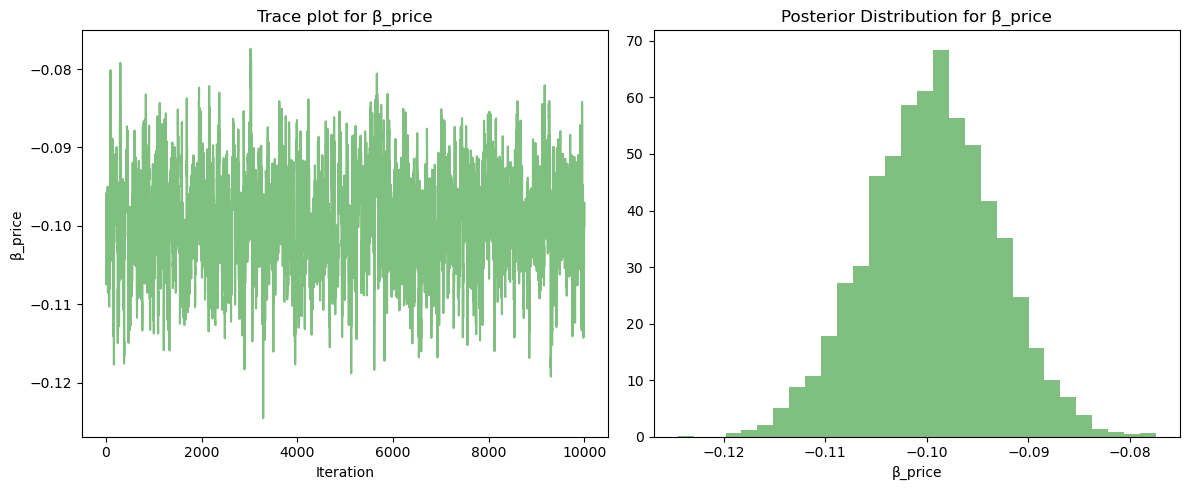

In [9]:
# Optional Trace and Histogram Plot (example for price)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(posterior_samples[:, 3], color='green', alpha=0.5)
plt.title("Trace plot for β_price")
plt.xlabel("Iteration")
plt.ylabel("β_price")

plt.subplot(1, 2, 2)
plt.hist(posterior_samples[:, 3], bins=30, density=True, color='green', alpha=0.5)
plt.title("Posterior Distribution for β_price")
plt.xlabel("β_price")
plt.tight_layout()
plt.show()

### 6. Discussion

The parameter estimates from both the maximum likelihood and Bayesian approaches align well with intuition about consumer behavior. The positive coefficients for brand_N and brand_P indicate that, on average, consumers prefer these brands over the baseline brand H, with a stronger preference for brand_N (Netflix) over brand_P (Prime Video). This suggests a clear brand hierarchy in perceived utility.  

The negative coefficient on price is both expected and meaningful. It implies that, holding other factors constant, an increase in price decreases the probability that a product is chosen. This is consistent with standard economic theory: consumers are price-sensitive and prefer cheaper options, all else being equal. The fact that \beta_{\text{price}} < 0 supports the validity of the model.  

Interestingly, the ad_Yes coefficient is also negative, suggesting that the presence of advertising reduces utility. In this context, it may be that ads are perceived as intrusive or associated with lower-value offerings, leading to a lower probability of choice for advertised options.  

To extend the model and better reflect real-world variation in consumer preferences, one could use a multilevel (hierarchical) model. In such models, individual-level parameters \beta_i are assumed to vary across respondents and are drawn from a population distribution (e.g., \beta_i \sim \mathcal{N}(\mu, \Sigma)). This captures heterogeneity by allowing each respondent to weigh attributes differently. Estimation involves recovering both individual preferences and the population-level parameters, typically via hierarchical Bayes or simulated maximum likelihood. This approach is widely used in practical conjoint analysis for more accurate prediction and segmentation.